# Exploratory Modelling
This notebook performs exploratory modeling to analyze base and extreme scenarios, helping to identify potential trade-offs in flood risk management policies.

In [21]:
"""
This script demonstrates the usage of the EMA Workbench for model-based decision-making. 
It sets up a dike model, defines parameters, and runs simulations to analyze the impact of different policy levers on flood risk management.
The dike model is investigated by setting all the levers to 0 and 1. 
It also includes a sensitivity analysis using Latin Hypercube Sampling (LHS) to explore the parameter space.
# The results are saved to a file and visualized using seaborn and matplotlib.
"""

# change this guys
import sys
sys.path.append('/Users/lorenzo/Desktop/Cartelle/Mbd project/MBD-repository/')

# module imports
from dike_model_function import DikeNetwork
import copy

# problem formulation imports
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

# EMA Workbench imports
from ema_workbench import (
    Model,
    RealParameter, 
    IntegerParameter,
    CategoricalParameter,
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    Scenario
)
from ema_workbench.util import save_results


# visualization and data analysis imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# sensitivity analysis imports
from SALib.sample.latin import sample as lhs_sample
from SALib.util import scale_samples


In [22]:

# Enable console logging so we can see EMA Workbench progress messages
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 1 is chosen
# As this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(1)

# Uncertainties are the parameters that are not controlled by the decision-maker
# They represent the uncertainties in the model that can affect the outcomes.
# Each `x` is a Real/Integer/CategoricalParameter with lower–upper bounds
for x in dike_model.uncertainties:
    print(repr(x))

# Make a deep copy so later edits don’t mutate the original model object
uncertainties = copy.deepcopy(dike_model.uncertainties)

# policy levers are the parameters that the decision-maker can control
# They represent the decisions that can be made to influence the outcomes.
# policy levers types (RealParameter/IntegerParameter) with lower-upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# Outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

Explore the behavior of the system in the absence of any release using 1000 scenarios

In [23]:
# Extract bounds for the uncertainties
#problem = {
#    'num_vars': len(uncertainties),
 #   'names': [unc.name for unc in uncertainties],
  #  'bounds': []
#}

#for unc in uncertainties:
 #   if isinstance(unc, (RealParameter, IntegerParameter)):
  #      problem['bounds'].append([unc.lower_bound, unc.upper_bound])
   # elif isinstance(unc, CategoricalParameter):
        # Handle categorical parameters separately
    #    problem['bounds'].append([0, len(unc.categories) - 1])

In [24]:
# Build the SALib ‘problem’ dict in one go
problem = {
    'num_vars': len(uncertainties),
    'names'   : [u.name for u in uncertainties],
    'bounds'  : [
        # For numeric uncertainties keep their true bounds,
        # for categorical ones use an index range 0 … (k-1)
        [u.lower_bound, u.upper_bound] if isinstance(u, (RealParameter, IntegerParameter))
        else [0, len(u.categories) - 1]
        for u in uncertainties
    ]
}

In [25]:
num_scenarios = 40000

In [26]:
# create a new dictionary with all levers set to zero
lever_settings = {lever.name: 0 for lever in levers}

# Define the first policy with all levers set to zero
policy1 = Policy("Zero Policy", **lever_settings)
# Define the second policy with all levers set to one
policy2 = Policy("One Policy", **{lever.name: 1 for lever in levers})

In [27]:
# Run the experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=num_scenarios, policies=[zero_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|████████████████████████████████████| 40000/40000 [26:17<00:00, 25.35it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [28]:
# Save the results to a file
save_results((experiments, outcomes), './data/exploratory_results_40000_zero_policy.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/lorenzo/Desktop/Cartelle/Mbd project/MBD-repository/data/exploratory_results_40000_zero_policy.tar.gz


In [29]:
# run the experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments1, outcomes1 = evaluator.perform_experiments(scenarios=num_scenarios, policies=[one_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|████████████████████████████████████| 40000/40000 [24:12<00:00, 27.54it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [30]:
# Save the results to a file
save_results((experiments1, outcomes1), './data/exploratory_results_40000_one_policy.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/lorenzo/Desktop/Cartelle/Mbd project/MBD-repository/data/exploratory_results_40000_one_policy.tar.gz


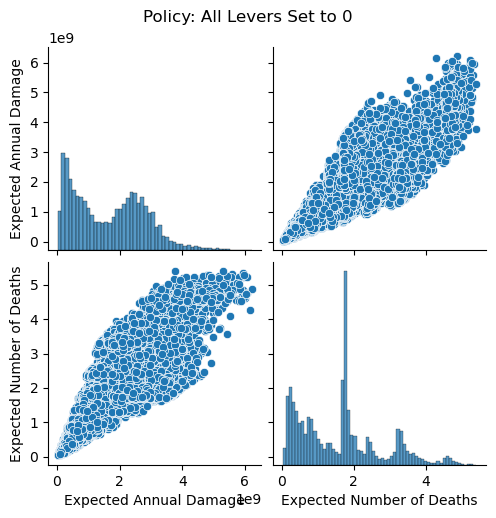

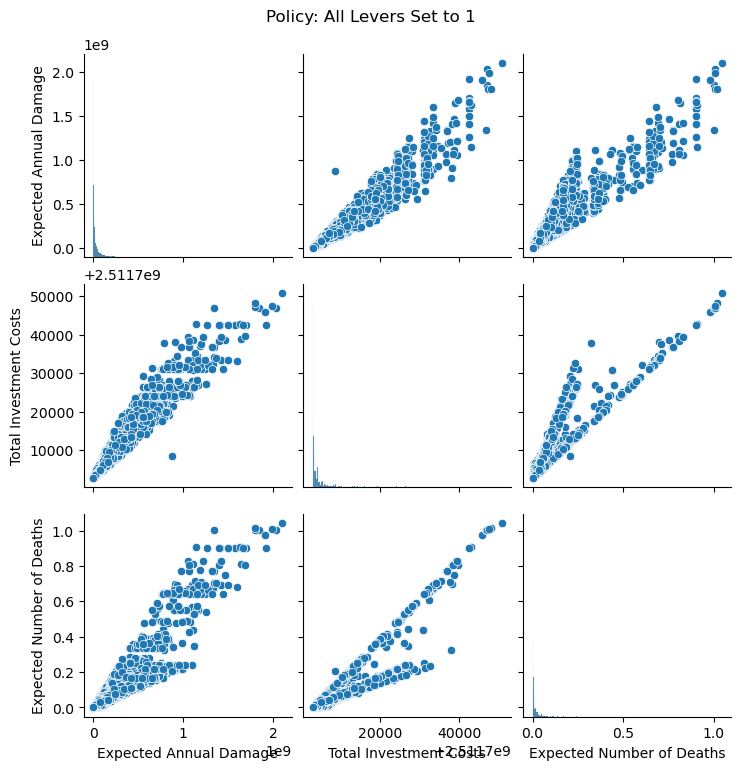

In [31]:
# Conversion of experiments and outcomes to DataFrames
# First the zero policy
experiments_zero_df = pd.DataFrame(experiments) 
outcomes_zero_df = pd.DataFrame(outcomes)

# Second the one policy
experiments_one_df = pd.DataFrame(experiments1)
outcomes_one_df = pd.DataFrame(outcomes1)

# Combination of the experiments and outcomes DataFrames
# This allows us to analyze the results in a single DataFrame
results_zero_df = pd.concat([experiments_zero_df, outcomes_zero_df], axis=1)
results_one_df = pd.concat([experiments_one_df, outcomes_one_df], axis=1)

# Creation of pair plots for policy where levers are set to 0
# only plot the expected annual damage and expected number of deaths because the other outcomes are not 0 for no policy
sns.pairplot(results_zero_df, vars=['Expected Annual Damage','Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 0', y=1.02)
plt.show()

# Generate pair plots for policy where levers are set to 1
sns.pairplot(results_one_df, vars=['Expected Annual Damage', 
                                        'Total Investment Costs', 'Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 1', y=1.02)
plt.show()